In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Задача 1

На семинаре мы разбирали классификацию изображений на основе kNN. В этом задании мы вернемся к датасету [MNIST](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) и попробуем улучшить результат, полученный на семинаре.

Для начала, загрузите данные и разделите их на обучающую и тестовую части.

In [2]:
digits = load_digits()
data = digits.data
target = digits.target
train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size=0.2, random_state=42)

Число соседей в модели kNN является необучаемым параметром т.е. гиперпараметром который выставляется вручную. Как мы видели на лекции, выбор оптимального значения $k$ важен, так как слишком маленькое значение может привести к переобучению, а слишком большое — к недообучению.

Постройте график зависимости точности (`accuracy_score`) предсказания kNN от значения $k$ (от 1 до 20) для обучающей и тестовой выборок.

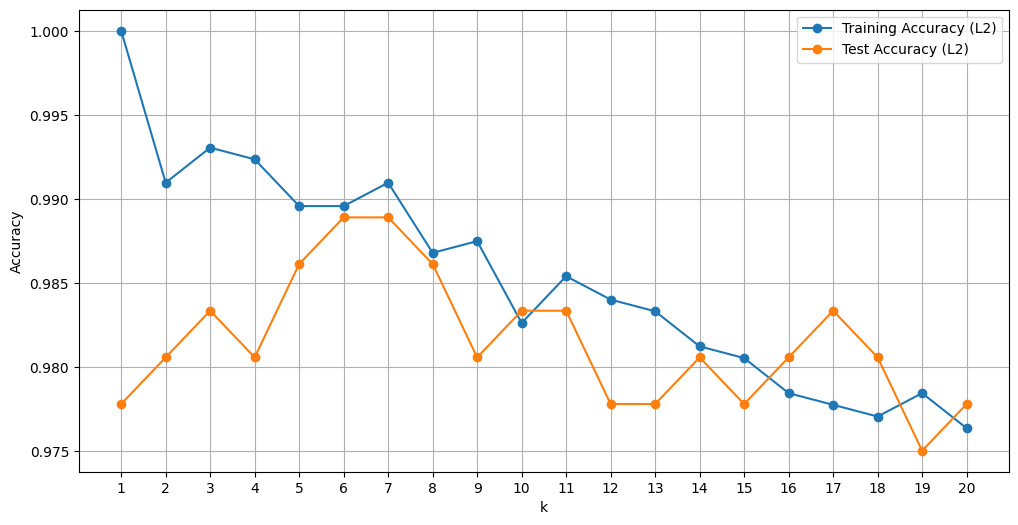

In [5]:
def evaluate_knn_accuracy(train_data, train_labels, test_data, test_labels, k_values, metric='euclidean'):
    train_accuracy_scores = []
    test_accuracy_scores = []

    for k in k_values:
        knn_classifier = KNeighborsClassifier(n_neighbors=k, p=2 if metric == 'euclidean' else 1)
        knn_classifier.fit(train_data, train_labels)
        train_predictions = knn_classifier.predict(train_data)
        test_predictions = knn_classifier.predict(test_data)

        train_accuracy = accuracy_score(train_labels, train_predictions)
        test_accuracy = accuracy_score(test_labels, test_predictions)

        train_accuracy_scores.append(train_accuracy)
        test_accuracy_scores.append(test_accuracy)
    return train_accuracy_scores, test_accuracy_scores

k_values = range(1, 21)
train_accuracy_l2, test_accuracy_l2 = evaluate_knn_accuracy(train_data, train_labels, test_data, test_labels, k_values, metric='euclidean')

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_accuracy_l2, label='Training Accuracy (L2)', marker='o')
plt.plot(k_values, test_accuracy_l2, label='Test Accuracy (L2)', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- fe9171a6e245a953987df27f018c61c2 -->
&#x2753; **Вопрос** &#x2753;

> Почему при $k = 1$ на тренировочной выборке метрика качества составляет 100%.

**Ваш ответ:** при k = 1 ближайшим соседом будет он сам, поэтому точность всегда 100%

<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- cdb15caec1719ca7ba80d25b716879ca -->
Помимо числа соседей гиперпараметром модели также является *метрика расстояния* между объектами.

> По умолчанию используется *Евклидова метрика* ($L_2$), согласно которой расстояние между двумя точками $x_1 =(x_{11}, …, x_{1d})$ и $x_2=(x_{21},…,x_{2n})$ в $d$-мерном пространстве определяется как:
$$\rho(x_1, x_2) = \sqrt{\sum^d_{j=1}\left(x_{1j} - x_{2j}\right)^2}.$$
>
> Иногда в kNN имеет смысл использовать другие метрики, например *метрику Манхэттена* ($L_1$).
$$\rho(x_1, x_2) = \sum^d_{j=1} \left|x_{1j} - x_{2j}\right|.$$
>
> Выбор одной из них зависит от особенностей задачи и данных. В частности,
>
> * метрика Манхэттена менее чувствительна к выбросам, чем евклидово расстояние, что делает её полезной для данных с сильным шумом или при наличии аномалий;
>
> * в задачах с разреженными данными (например, текстовые данные, представленные в виде векторов) метрика Манхэттена может работать лучше, чем евклидово расстояние.

Проведите аналогичный эксперимент используя в качестве гиперпараметра $L_1$-метрику (выясните сами, как ее задать). Выведите на одном графике зависимости точности (accuracy) от значения $k$ для обучающей и тестовой выборок для обоих метрик.

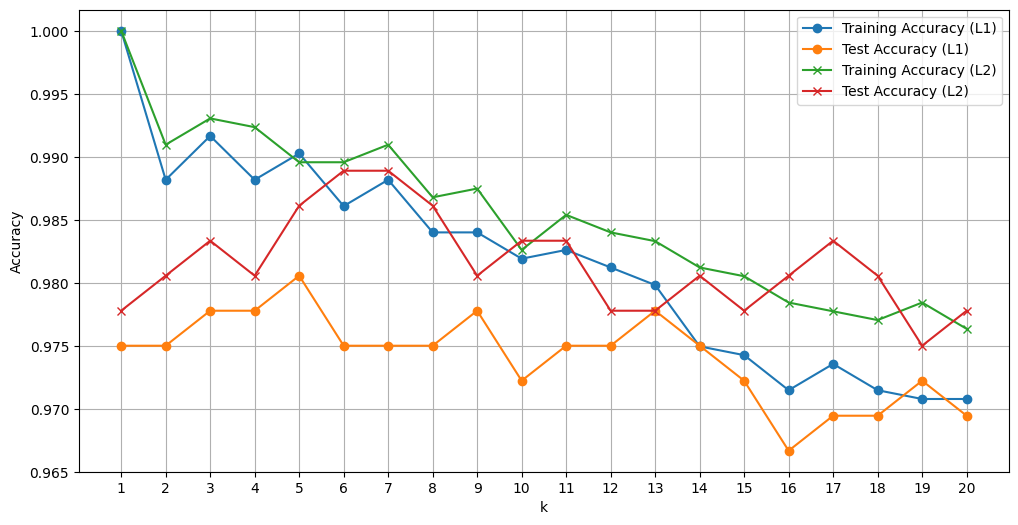

In [7]:
train_accuracy_l1, test_accuracy_l1 = evaluate_knn_accuracy(train_data, train_labels, test_data, test_labels, k_values, metric='manhattan')

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_accuracy_l1, label='Training Accuracy (L1)', marker='o')
plt.plot(k_values, test_accuracy_l1, label='Test Accuracy (L1)', marker='o')
plt.plot(k_values, train_accuracy_l2, label='Training Accuracy (L2)', marker='x')
plt.plot(k_values, test_accuracy_l2, label='Test Accuracy (L2)', marker='x')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

&#x2754; **Вопрос** &#x2754;

> Как вы думаете почему смена метрики так сильно повлияла на характер кривых?

**Ваш ответ:** Вероятно это происходит из-за того, что метрика манхэтттена подавляет шумы, которые важны для точности, поэтому он показывает хуже результаты.

**Выводы:** Метрика манхэттена более точная на этих данных, поэтому следует выбрать её

### Задача 2

#### 0. Подготовка данных

Титаник был крупнейшим пассажирским судном в 1912—1913 годах. Во время первого рейса затонул в северной Атлантике, столкнувшись с айсбергом в ночь с 14 на 15 апреля 1912 года, при этом погибло 1502 из 2224 пассажиров и членов экипажа. Данные о пассажирах были собраны в таблицы, которые можно скачать с <a href="https://www.kaggle.com/c/titanic/data" target="_blank">Kaggle</a>. Эти данные часто используются в качестве обучающих в анализе данных.


Загрузите данные с помощью `pandas`.

In [8]:
titanic = pd.read_csv("train.csv").dropna()
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


Для лучшего понимания процесса работы с данными, уточним ключевые термины.

> **Объект** — это единица данных, представленная набором признаков и используемая для обучения или предсказаний модели. В данной задаче являются пассажиры, им соответствуют *строки* таблицы данных.
>
> **Признаки (features)** — это характеристики, которые описывают объекты в данных. В таблицах данных они обычно соответствуют *колонкам*. В данной задаче мы будем работать со следующими признаками
>
> * `Pclass` — класс билета (1 = первый класс, 2 = второй класс, 3 = третий класс);
>
> * `Age` — возраст пассажира;
>
> * `SibSp` — количество братьев, сестер или супругов на борту;
>
> * `Parch` — количество родителей или детей на борту;
>
> * `Fare` — стоимость билета.
>
> **Таргет (target)** — это целевая переменная, которую мы хотим предсказать. В данной задаче мы будем предсказывать `Survived` — бинарная переменная, указывающая, выжил ли пассажир (1) или нет (0). Значения этой переменной имеются для обучающего набора данных, а для тестого — нет.

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак, который мы хотим предсказать.

In [11]:
features_columns = ["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare"]
target_column = "Survived"  # Целевой признак

X, y = titanic[features_columns], titanic[target_column]

В данных могут присутствовать пропуски.
Посмотрите, сколько объектов имеют хотя бы один пропуск и удалите их.

In [12]:
missing_values_count = titanic.isnull().any(axis=1).sum()
print(f"Количество пропусков в данных: {missing_values_count}")
cleaned_titanic = titanic.dropna()
X, y = cleaned_titanic[features_columns], cleaned_titanic[target_column]

Количество пропусков в данных: 0


Разделите данные по строкам на тренировочную и тестовую выборки случайным образом в соотношении 7:3.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 1. Исследование

> &#x2757; **Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*.

Проведите визуальный анализ данных чтобы понять, как различные признаки влияют на целевой.

*Не забывайте про информативность и эстетичность графиков.*

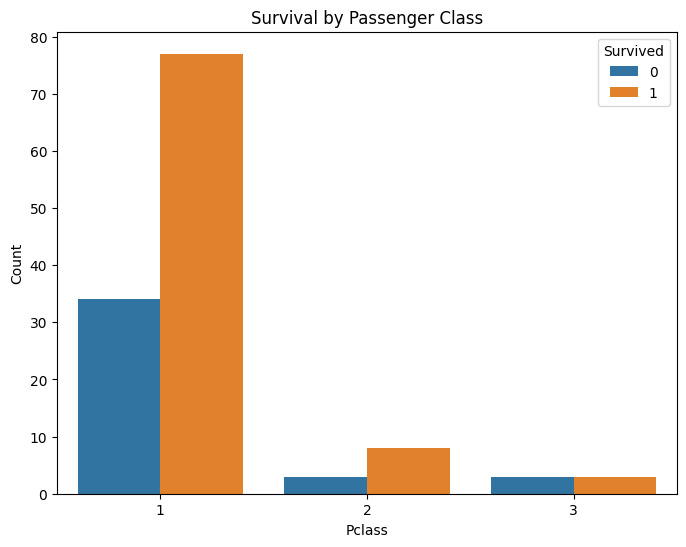

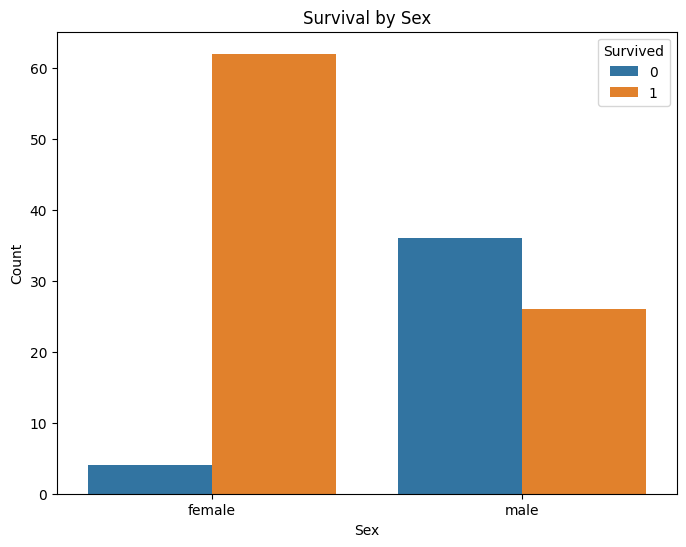

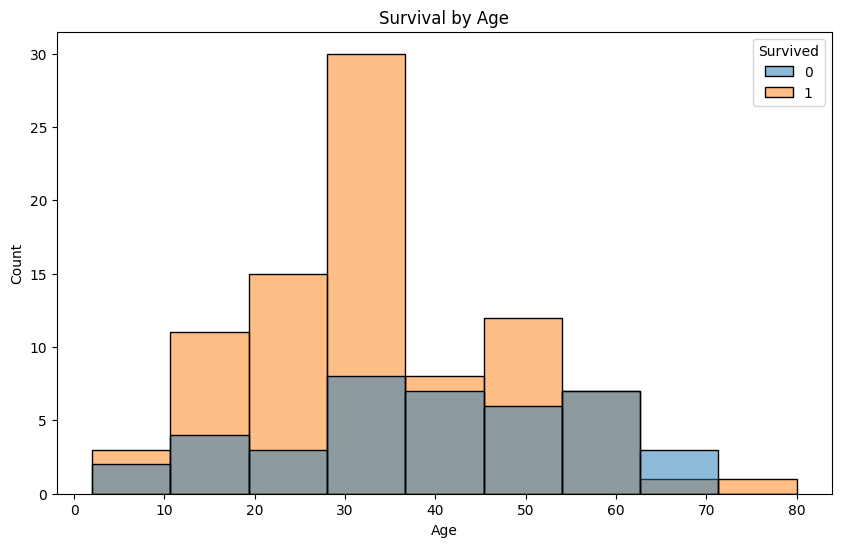

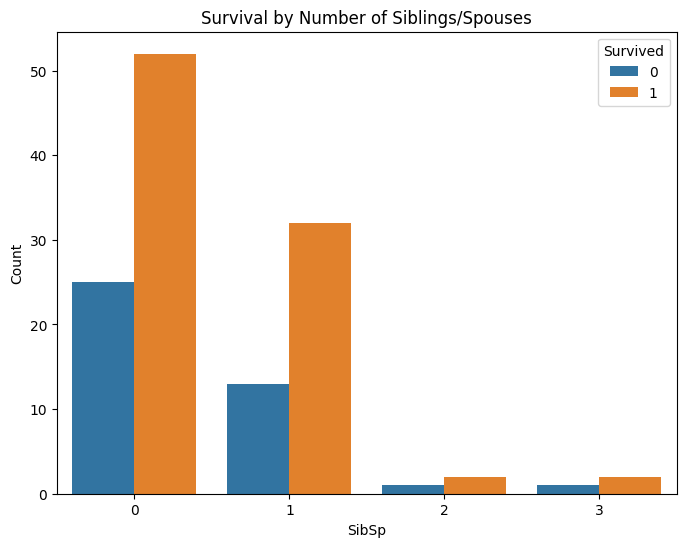

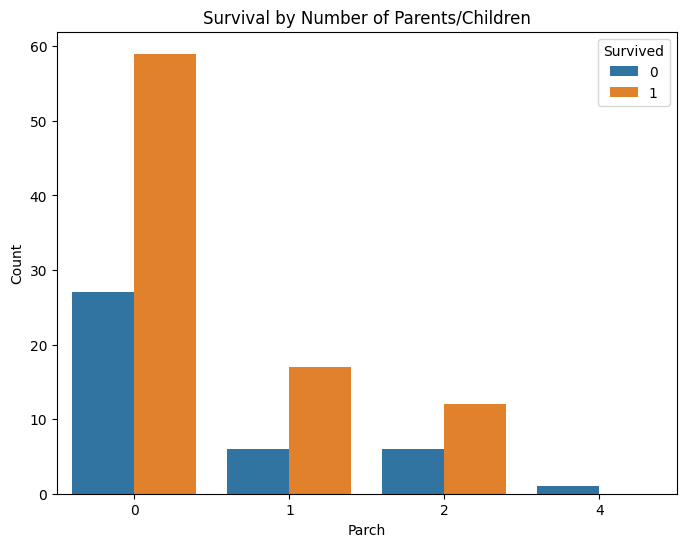

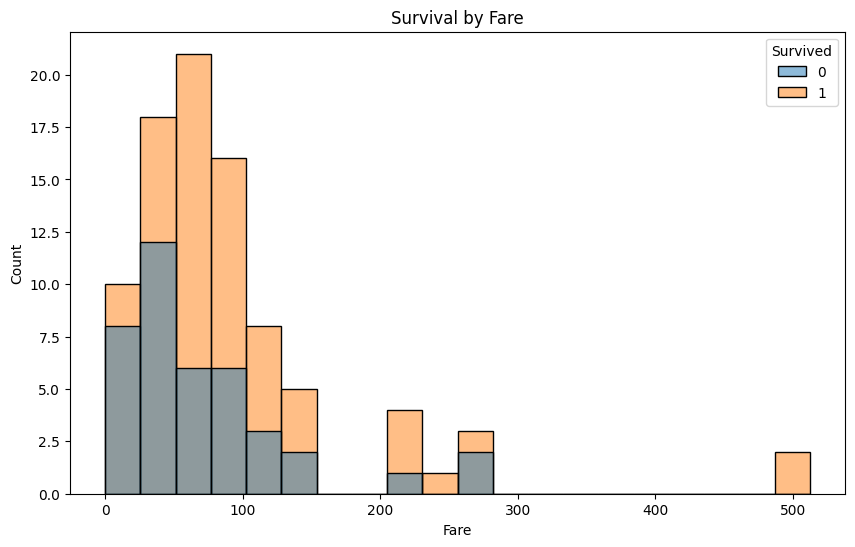

In [16]:
eda_data = X_train.copy()
eda_data['Survived'] = y_train

def plot_categorical(column, title, xticks=None):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, hue='Survived', data=eda_data)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    if xticks:
        plt.xticks(xticks[0], xticks[1])
    plt.show()

def plot_numerical(column, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=eda_data, x=column, hue='Survived')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


plot_categorical('Pclass', 'Survival by Passenger Class')
plot_categorical('Sex', 'Survival by Sex')
plot_numerical('Age', 'Survival by Age')
plot_categorical('SibSp', 'Survival by Number of Siblings/Spouses')
plot_categorical('Parch', 'Survival by Number of Parents/Children')
plot_numerical('Fare', 'Survival by Fare')

#### 2. Классификация методом ближайшего соседа

В данной части задачи оставим только признаки `'Pclass'`, `'Age'`, `'Sex'`,`'Fare'`.


<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- 3bfbe10cf933e1302c2f524a99acfa54 -->
Постройте классификатор методом ближайшего соседа. Обучите его и оцените качество модели. Сравните с предыдущим методом.

Пока никаких преобразований данных делать не нужно.




In [20]:
X_subset, y_subset = cleaned_titanic[['Pclass', 'Age', 'Sex', 'Fare']], cleaned_titanic[target_column]
X_subset["Sex"] = X_subset["Sex"].map({"male": 0, "female": 1})

X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)

knn_unscaled = KNeighborsClassifier(n_neighbors=5)
knn_unscaled.fit(X_train_subset, y_train_subset)

y_pred_unscaled = knn_unscaled.predict(X_test_subset)
accuracy_unscaled = accuracy_score(y_test_subset, y_pred_unscaled)
print(f"Точность: {accuracy_unscaled}")

Точность: 0.6545454545454545


<ipython-input-20-6ae9d9d67ead>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_subset["Sex"] = X_subset["Sex"].map({"male": 0, "female": 1})


<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- 21227e76b996f62c6c83ee38ce486bdf -->
Попробуем улучшить результаты предсказаний, для этого надо сначала посмотреть на сами данные. Выведите значение минимального и максимального объекта для каждого признака.

In [23]:
feature_ranges = {}
for column in X_subset.columns:
    min_value = X_subset[column].min()
    max_value = X_subset[column].max()
    feature_ranges[column] = (min_value, max_value)
    print(f"{column}: Min = {min_value}, Max = {max_value}")

Pclass: Min = 1, Max = 3
Age: Min = 0.92, Max = 80.0
Sex: Min = 0, Max = 1
Fare: Min = 0.0, Max = 512.3292


Как мы видим данные в каждом столбце распределены очень по-разному.

&#x2753; **Вопрос** &#x2753;
> Как это может повлиять на работу kNN, почему?

**Ваш ответ:**  Признаки с наибольшим значением будут сильнее влиять на результат, чем другие


Для решения этой проблемы нужно привести признаки к единому масштабу. Существует много методов масштабирования, примените **минимаксную нормализацию**

  
> **Минимакс** &mdash; линейное преобразование данных в диапазоне $[0, 1]$, где минимальное и максимальное масштабируемые значения соответствуют 0 и 1 соответственно.
> Реализуется оно по следующей формуле:
>
> $$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{M_j - m_j}$$
>
> где $x_{ij}$ &mdash; значение признака $j$ для объекта $i$, а $m_j$ и $M_j$ &mdash; минимальное и максимальное значения признака $j$ в обучающем наборе данных.  
> В модуле `sklearn.preprocessing` есть [класс](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) `MinMaxScaler`, который реализует эту операцию. Давайте рассмотрим методы этого класса подробнее:
>
> * `fit(X)`: вычисляет минимальные и максимальные значения для каждого признака.
>
> * `transform(X)`: применяет масштабирование к данным.
>
> * `fit_transform(X)`: объединяет оба метода, сначала подгоняя модель, а затем трансформируя данные.
>
> * `inverse_transform(X)`: восстанавливает исходные данные из масштабированных.


Не забывайте, что существуют и другие методы масштабирования данных.

<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- 3cf8b0b6b0402c9ceb439c2de6ee4276 -->


Отмасштабируйте данные

In [24]:
minmax_scaler = MinMaxScaler()
X_scaled_subset = minmax_scaler.fit_transform(X_subset)
X_scaled_subset = pd.DataFrame(X_scaled_subset, columns=X_subset.columns, index=X_subset.index)

Теперь выведите значения максимума и минимума нормализованных признаков. Обратите внимание `MinMaxScaler` возвращается объект в виде `np.ndarray`.

In [26]:
scaled_feature_ranges = {}
for column in X_scaled_subset.columns:
    min_value = X_scaled_subset[column].min()
    max_value = X_scaled_subset[column].max()
    scaled_feature_ranges[column] = (min_value, max_value)
    print(f"{column}: Min = {min_value}, Max = {max_value}")

Pclass: Min = 0.0, Max = 1.0
Age: Min = 0.0, Max = 1.0
Sex: Min = 0.0, Max = 1.0
Fare: Min = 0.0, Max = 1.0


Обучите модель и сравните результат предсказаний со нормализацией и без.

In [27]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled_subset, y_subset, test_size=0.3, random_state=42)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = knn_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test_scaled, y_pred_scaled)
print(f"Accuracy with scaling: {accuracy_scaled}")

Accuracy with scaling: 0.7272727272727273


**Вывод:** Новая модель получилась более точной, чем предыдущая

<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- 02a5bc7d6f2e8382a04db099c58ba6d1 -->
**А можем ли мы как-то еще повысить точность модели?**

Как мы видели, параметр $k$ числа соседей является необучаемым т.е. гиперпараметром, который выставляется вручную. Выбор оптимального значения $k$ важен, так как слишком маленькое значение может привести к переобучению, а слишком большое — к недообучению.



Постройте график зависимости точности (`accuracy_score`) от значения $k$ (от 1 до 20) для обучающей и тестовой выборок.

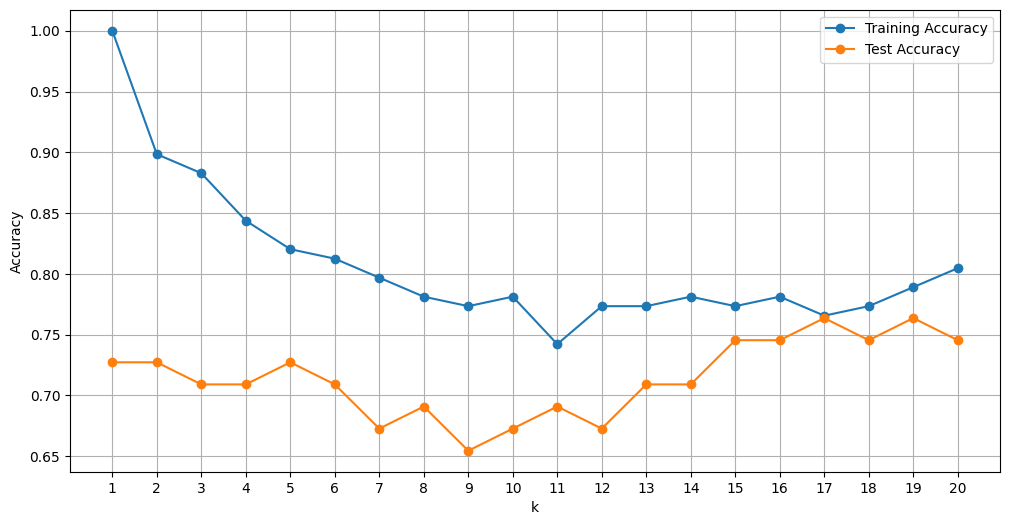

In [29]:
def evaluate_knn_accuracy(X_train, y_train, X_test, y_test, k_values):
    train_accuracy_scores = []
    test_accuracy_scores = []

    for k in k_values:
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        knn_classifier.fit(X_train, y_train)
        train_predictions = knn_classifier.predict(X_train)
        test_predictions = knn_classifier.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        train_accuracy_scores.append(train_accuracy)
        test_accuracy_scores.append(test_accuracy)

    return train_accuracy_scores, test_accuracy_scores


k_values = range(1, 21)
train_accuracy, test_accuracy = evaluate_knn_accuracy(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, k_values)

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(k_values, test_accuracy, label='Test Accuracy', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** Точность тестовой выборке становится максимальной при k равным 17 и 19, при этом точность на обучающей выборке разниться и следует выбрать максимальную из них, а именно при k равным 19, поэтому предпочтительнее использовать k = 19

# 2

1. Загрузите выборку Wine по адресу https://archive.ics.uci.edu/ml/machine-learningdatabases/wine/wine.data

In [31]:
wine_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

2. Извлеките из данных признаки и классы. Класс записан в первом столбце (три
варианта), признаки — в столбцах со второго по последний. Более подробно о сути
признаков можно прочитать по адресу https://archive.ics.uci.edu/ml/datasets/Wine

In [32]:
features = wine_data.iloc[:, 1:]
target = wine_data.iloc[:, 0]

3. Оценку качества необходимо провести методом кросс-валидации по 5 блокам (5-fold).
Создайте генератор разбиений, который перемешивает выборку перед формированием
блоков (shuffle=True). Для воспроизводимости результата, создавайте генератор KFold
с фиксированным параметром random_state=42. В качестве меры качества
используйте долю верных ответов (accuracy).

In [34]:
num_folds = 5
kfold_generator = KFold(n_splits=num_folds, shuffle=True, random_state=42)

def find_k_optimal(features, target, kfold):
    best_k = None
    best_mean_accuracy = 0.0
    mean_accuracies = []
    k_values = range(1, 51)

    for k in k_values:
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(knn_classifier, features, target, cv=kfold, scoring="accuracy")
        mean_accuracy = np.mean(cv_scores)
        mean_accuracies.append(mean_accuracy)

        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_k = k

    return best_k, best_mean_accuracy, mean_accuracies, k_values

4. Найдите точность классификации на кросс-валидации для метода k ближайших
соседей (sklearn.neighbors.KNeighborsClassifier), при k от 1 до 50. При каком k
получилось оптимальное качество? Чему оно равно (число в интервале от 0 до 1)?

In [37]:
optimal_k_unscaled, optimal_accuracy_unscaled, accuracy_values_unscaled, k_values = find_k_optimal(features, target, kfold_generator)

print(f"Оптимальное k: {optimal_k_unscaled}")
print(f"Точность при k={optimal_k_unscaled}: {optimal_accuracy_unscaled}")

Оптимальное k: 1
Точность при k=1: 0.7304761904761905


5. Произведите масштабирование признаков с помощью функции
sklearn.preprocessing.scale. Снова найдите оптимальное k на кросс-валидации.


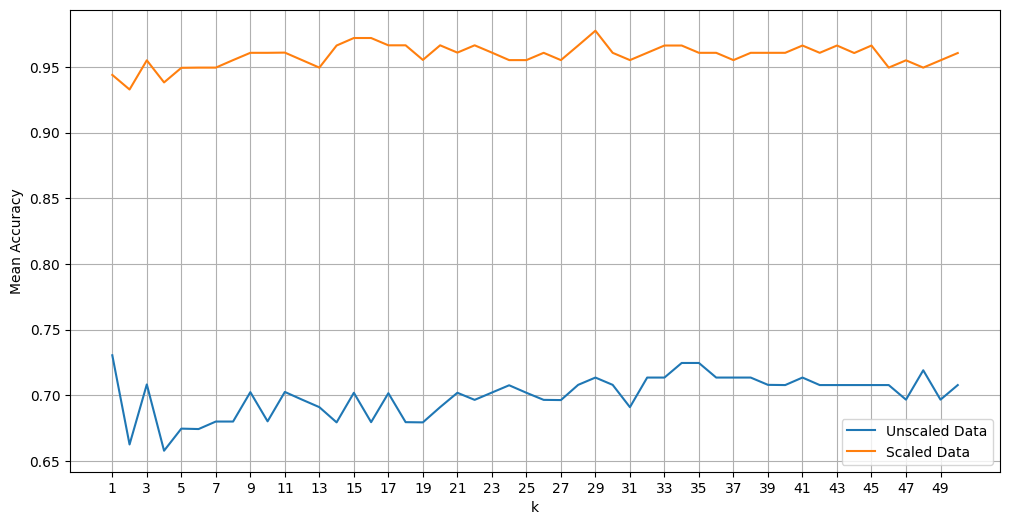

In [41]:
scaled_features = scale(features)

optimal_k_scaled, optimal_accuracy_scaled, accuracy_values_scaled, k_values = find_k_optimal(scaled_features, target, kfold_generator)

plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracy_values_unscaled, label='Unscaled Data')
plt.plot(k_values, accuracy_values_scaled, label='Scaled Data')
plt.xlabel('k')
plt.ylabel('Mean Accuracy')
plt.xticks(np.arange(1, 51, 2))
plt.legend()
plt.grid(True)
plt.show()

6. Какое значение k получилось оптимальным после приведения признаков к одному
масштабу? Как изменилось значение качества?

In [44]:
print(f"Оптимальное k: {optimal_k_scaled}")
print(f"Точность при k={optimal_k_scaled}: {optimal_accuracy_scaled}")
print(f"Точность улучшилась на: {optimal_accuracy_scaled - optimal_accuracy_unscaled}")

Оптимальное k: 29
Точность при k=29: 0.9776190476190475
Точность улучшилась на: 0.247142857142857


#3

1. Загрузите выборку Boston с помощью функции sklearn.datasets.load_boston(). Результатом
вызова данной функции является объект, у которого признаки записаны в поле data, а
целевой вектор — в поле target.


In [45]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

features = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

2. Приведите признаки в выборке к одному масштабу при помощи функции
sklearn.preprocessing.scale.

In [46]:
scaled_features = scale(features)

3. Переберите разные варианты параметра метрики p по сетке от 1 до 10 с таким шагом, чтобы
всего было протестировано 200 вариантов (используйте функцию numpy.linspace).
ИспользуйтеKNeighborsRegressor с n_neighbors=5 и weights=’distance’ — данный параметр
добавляет в алгоритм веса, зависящие от расстояния до ближайших соседей. В качестве
метрики качества используйте среднеквадратичную ошибку (параметр
scoring=’mean_squared_error’ у cross_val_score;при использованиибиблиотекиscikit-learn
версии 18.0.1 и выше необходимо указывать scoring=’neg_mean_squared_error’). Качество
оценивайте, как и в предыдущем задании, с помощью кросс-валидации по 5 блокам с
random_state = 42, не забудьте включить перемешивание выборки (shuffle=True).


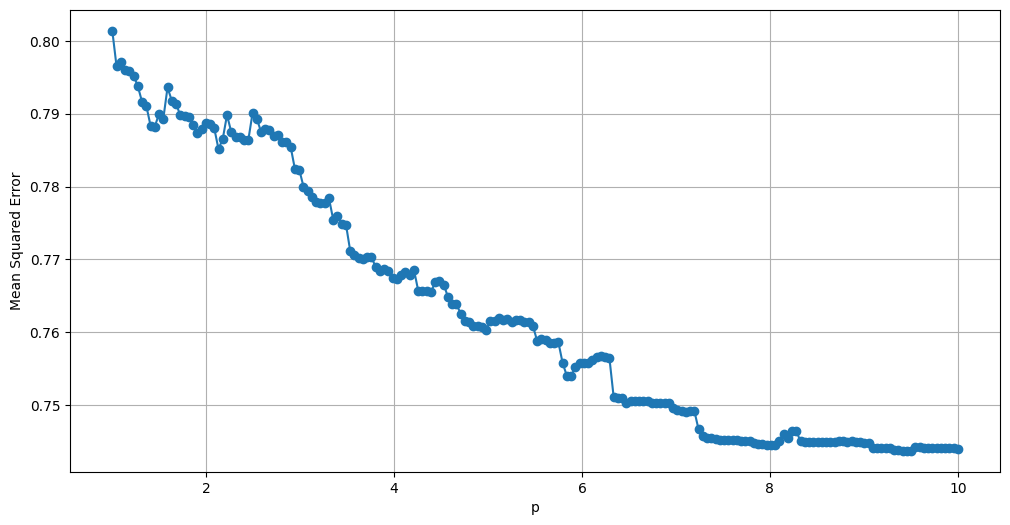

In [68]:
num_p_values = 200
p_values = np.linspace(1, 10, num_p_values)

num_folds = 5
kfold_generator = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_p_value = None
best_mse = float('inf')
mse_scores = []

for p in p_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance', p=p)
    cv_scores = cross_val_score(knn_regressor, scaled_features, target, cv=kfold_generator)

    mean_mse = np.mean(cv_scores)
    mse_scores.append(mean_mse)

    if mean_mse < best_mse:
        best_mse = mean_mse
        best_p_value = p

plt.figure(figsize=(12, 6))
plt.plot(p_values, mse_scores, marker='o')
plt.xlabel('p')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

4. Определите,прикаком pкачествона кросс-валидацииоказалось оптимальным. Обратите
внимание, что cross_val_score возвращает массив показателей качества по блокам;
необходимо максимизировать среднее этих показателей.

In [69]:
print(f"лучшее значение p: {best_p_value}")
print(f"Лучшая среднеквадратичная ошибка: {best_mse}")

лучшее значение p: 9.50251256281407
Лучшая среднеквадратичная ошибка: 0.7437393800192152
